In [1]:
import os
import re
import random
from math import sqrt
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ks_2samp

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.1.final.0
python-bits      : 64
OS               : Windows
OS-release       : 7
machine          : AMD64
processor        : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 0.25.3
numpy            : 1.17.4
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 39.0.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.10.2
pandas_datareader: None
bs4              : None
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       : 3

In [2]:
def _log(str):
    os.system(f'echo \"{str}\"')
    print(str)

In [3]:
NAN = '__NAN__'
INPUT_ROOT = '../input/data-science-bowl-2019'
JOIN_KEY = ['installation_id', 'game_session', 'title']
TARGET = 'accuracy_group'
FEATURES = {
    'event_id', 
    'game_session', 
    'timestamp', 
    'installation_id', 
    'event_count',
    'event_code', 
    'game_time', 
    'title', 
    'type', 
    'world',
    'event_data'
}
EVENT_CODES = ['2000', '2010', '2020', '2025', '2030', '2035', '2040', '2050', '2060', '2070', '2075', '2080', '2081', '2083', '3010', '3020', '3021', '3110', '3120', '3121', '4010', '4020', '4021', '4022', '4025', '4030', '4031', '4035', '4040', '4045', '4050', '4070', '4080', '4090', '4095', '4100', '4110', '4220', '4230', '4235', '5000', '5010']
SEED = 31
FOLDS = 3
ESTIMATORS = 1000

In [4]:
def _init():
    # Characters such as empty strings '' or numpy.inf are considered NA values
    pd.set_option('use_inf_as_na', True)
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    
    
_init()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [6]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(INPUT_ROOT):
    for filename in filenames:
        _log(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/data-science-bowl-2019\sample_submission.csv
../input/data-science-bowl-2019\test.csv
../input/data-science-bowl-2019\test.csv.zip
../input/data-science-bowl-2019\train.csv
../input/data-science-bowl-2019\train.csv.zip
../input/data-science-bowl-2019\train_labels.csv
../input/data-science-bowl-2019\train_labels.csv.zip


In [7]:
%%time
train_raw = pd.read_csv(f'{INPUT_ROOT}/train.csv', usecols=FEATURES)
train_labels = pd.read_csv(f'{INPUT_ROOT}/train_labels.csv', usecols=JOIN_KEY + [TARGET])
test_raw = pd.read_csv(f'{INPUT_ROOT}/test.csv', usecols=FEATURES)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 4 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
accuracy_group     17690 non-null int64
dtypes: int64(1), object(3)
memory usage: 552.9+ KB
Wall time: 52.1 s


# Add labels to train data

In [8]:
def _remove_unlabelled_data(train_raw, train_labels):
    return train_raw[train_raw['installation_id'].isin(train_labels['installation_id'].unique())]


train_raw = _remove_unlabelled_data(train_raw, train_labels)

In [9]:
%%time
def _add_labels(train_raw, train_labels, on):
    return pd.merge(train_raw, train_labels, on=on, how='left')


train_raw = _add_labels(train_raw, train_labels, on=JOIN_KEY)
del train_labels

Wall time: 4.47 s


# Extract event data JSON

In [10]:
def _concat_columns(df1, df2):
    """Concatenate the columns of two pandas dataframes in the order of the operands.
    Both dataframes must have the same number of rows.
    """
    assert len(df1) == len(df2)
    res = pd.concat([df1, df2.reindex(df1.index)], axis=1, join='inner')
    assert len(res) == len(df1)
    return res
    

def _extract_event_data(df, keep_cols, chunk_size=1000000):
    res = pd.DataFrame()
    _len = len(df)
    for i in tqdm(range(0, _len, chunk_size)):
        if i + chunk_size < _len:
            chunk = df[i:i + chunk_size].copy()
        else:
            chunk = df[i:].copy()
        ed = pd.io.json.json_normalize(chunk['event_data'].apply(json.loads)).add_prefix('ed.')
        ed = ed[keep_cols]
        chunk = _concat_columns(chunk, ed)
        res = pd.concat([res, chunk], ignore_index=True, sort=False)
    assert len(df) == len(res)
    return res


keep_cols = ['ed.identifier', 'ed.duration', 'ed.level', 'ed.round', 'ed.correct', 'ed.misses',
            'ed.weight', 'ed.total_duration', 'ed.source']
train_raw = _extract_event_data(train_raw, keep_cols)
test_raw = _extract_event_data(test_raw, keep_cols)

100%|████████████████████████████████████████████████████| 2/2 [01:38<00:00, 49.45s/it]


In [11]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 20 columns):
event_id             1156414 non-null object
game_session         1156414 non-null object
timestamp            1156414 non-null object
event_data           1156414 non-null object
installation_id      1156414 non-null object
event_count          1156414 non-null int64
event_code           1156414 non-null int64
game_time            1156414 non-null int64
title                1156414 non-null object
type                 1156414 non-null object
world                1156414 non-null object
ed.identifier        337810 non-null object
ed.duration          336619 non-null float64
ed.level             84208 non-null float64
ed.round             598718 non-null float64
ed.correct           69806 non-null object
ed.misses            23658 non-null float64
ed.weight            50353 non-null float64
ed.total_duration    170228 non-null float64
ed.source            144623 non-null obje

In [12]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734558 entries, 0 to 7734557
Data columns (total 21 columns):
event_id             object
game_session         object
timestamp            object
event_data           object
installation_id      object
event_count          int64
event_code           int64
game_time            int64
title                object
type                 object
world                object
accuracy_group       float64
ed.identifier        object
ed.duration          float64
ed.level             float64
ed.round             float64
ed.correct           object
ed.misses            float64
ed.weight            float64
ed.total_duration    float64
ed.source            object
dtypes: float64(7), int64(3), object(11)
memory usage: 1.2+ GB


In [13]:
# All event ids in test set also exist in train set
test_set = set(test_raw['event_id'])
train_set = set(train_raw['event_id'])
vs = test_set - train_set
_log(f'{len(vs)} event_ids exist in test set but not train set.')

0 event_ids exist in test set but not train set.


In [14]:
EVENT_IDS = sorted(list(set(train_raw['event_id']) | set(test_raw['event_id'])))
_log(f'{len(EVENT_IDS)} EVENT_IDS={EVENT_IDS}')

379 EVENT_IDS=['0086365d', '00c73085', '01ca3a3c', '022b4259', '02a42007', '0330ab6a', '0413e89d', '04df9b66', '05ad839b', '06372577', '070a5291', '08fd73f3', '08ff79ad', '0a08139c', '0ce40006', '0d18d96c', '0d1da71f', '0db6d71d', '119b5b02', '1325467d', '1340b8d7', '1375ccb7', '13f56524', '14de4c5d', '155f62a4', '1575e76c', '15a43e5b', '15ba1109', '15eb4a7d', '15f99afc', '160654fd', '16667cc5', '16dffff1', '17113b36', '19967db1', '1996c610', '1af8be29', '1b54d27f', '1bb5fbdb', '1beb320a', '1c178d24', '1cc7cfca', '1cf54632', '1f19558b', '222660ff', '2230fab4', '250513af', '25fa8af4', '262136f4', '26a5a3dd', '26fd2d99', '27253bdc', '28520915', '28a4eb9a', '28ed704e', '28f975ea', '29a42aea', '29bdd9ba', '29f54413', '2a444e03', '2a512369', '2b058fe3', '2b9272f4', '2c4e6db0', '2dc29e21', '2dcad279', '2ec694de', '2fb91ec1', '30614231', '30df3273', '31973d56', '3323d7e9', '33505eae', '3393b68b', '363c86c9', '363d3849', '36fa3ebe', '37937459', '37c53127', '37db1c2f', '37ee8496', '38074c54', '

In [15]:
TITLES = test_raw['title'].unique()
test_raw['title'].value_counts()

Bottle Filler (Activity)         112223
Scrub-A-Dub                       96619
Chow Time                         93142
Sandcastle Builder (Activity)     82132
Fireworks (Activity)              61032
Bug Measurer (Activity)           59886
Bubble Bath                       55264
Dino Drink                        53989
Dino Dive                         49368
Crystals Rule                     46867
Chicken Balancer (Activity)       45874
All Star Sorting                  45863
Flower Waterer (Activity)         43819
Happy Camel                       39806
Pan Balance                       38649
Watering Hole (Activity)          35367
Air Show                          27119
Egg Dropper (Activity)            25941
Leaf Leader                       25574
Cauldron Filler (Assessment)      23440
Mushroom Sorter (Assessment)      21962
Bird Measurer (Assessment)        20086
Cart Balancer (Assessment)        19235
Chest Sorter (Assessment)         17904
Crystal Caves - Level 2            1450


In [16]:
TYPES = test_raw['type'].unique()
test_raw['type'].value_counts()

Game          572260
Activity      466274
Assessment    102627
Clip           15253
Name: type, dtype: int64

In [17]:
WORLDS = test_raw['world'].unique()
test_raw['world'].value_counts()

MAGMAPEAK       511291
TREETOPCITY     332295
CRYSTALCAVES    311387
NONE              1441
Name: world, dtype: int64

In [18]:
test_raw['ed.source'].value_counts()

resources    64271
scale         9336
right         8586
left          7890
7             6791
9             5974
8             5581
10            5106
11            4514
2             4124
5             3457
12            3376
4             3186
1             2816
N/A           2770
6             2045
3             2045
middle        1144
Heaviest       641
Heavy          552
Lightest       418
Name: ed.source, dtype: int64

In [19]:
test_raw['ed.identifier'].value_counts()

1438                                                                                                                                                                                                                                                                                        14812
1437                                                                                                                                                                                                                                                                                         6738
Dot_SoCool                                                                                                                                                                                                                                                                                   6594
507                                                                                                                               

In [20]:
vs = sorted(train_raw['type'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['Activity', 'Assessment', 'Clip', 'Game']


In [21]:
vs = sorted(train_raw['world'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['CRYSTALCAVES', 'MAGMAPEAK', 'NONE', 'TREETOPCITY']


In [22]:
vs = sorted(train_raw['event_code'].unique())
_log(f'{len(vs)} train_raw type={vs}')

42 train_raw type=[2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010]


In [23]:
vs = sorted(train_raw['title'].unique())
_log(f'{len(vs)} train_raw titles={vs}')

44 train_raw titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [24]:
vs = sorted(test_raw['title'].unique())
_log(f'{len(vs)} test titles={vs}')

44 test titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [25]:
def _transform_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


train_raw = _transform_timestamp(train_raw)
test_raw = _transform_timestamp(test_raw)

In [26]:
%%time
def _set_string_type(df, cols):
    df[cols] = df[cols].fillna(NAN).astype(str)
    return df


cols = ['event_code', 'timestamp', 'ed.identifier', 'ed.source']
train_raw = _set_string_type(train_raw, cols=cols)
test_raw = _set_string_type(test_raw, cols=cols)

Wall time: 1min 27s


In [27]:
%%time
def _sort_it(df):
    return df.sort_values(by=['installation_id', 'timestamp'])


train_raw = _sort_it(train_raw)
test_raw = _sort_it(test_raw)

Wall time: 29.1 s


# Multiple accuracy groups per installation id
In the train set, there are multiple accuracy groups per installation id. The task is to predict the accuracy group of the **last** assessment for a given installation id.

In [28]:
vs = train_raw[train_raw[TARGET].notna()].groupby('installation_id')[TARGET].nunique()
vs

installation_id
0006a69f    3
0006c192    3
00129856    1
001d0ed0    3
00225f67    1
           ..
ff9305d7    2
ff9715db    4
ffc90c32    2
ffd2871d    1
ffeb0b1b    2
Name: accuracy_group, Length: 3614, dtype: int64

In [29]:
def _log_smoothing(df, cols):
    for col in cols:
        df[col] = np.log(df[col] + 1)
    return df


#cols = ['event_count', 'game_time']
#train = _log_smoothing(train, cols)
#test = _log_smoothing(test, cols)

# Train-test split not by time
Both train and test sets span the same time period.

In [30]:
_log(f'train_raw[timestamp] is from {train_raw.timestamp.min()} to {train_raw.timestamp.max()}')
_log(f'test_raw[timestamp] is from {test_raw.timestamp.min()} to {test_raw.timestamp.max()}')

train_raw[timestamp] is from 2019-07-23 14:38:25.256000+00:00 to 2019-10-14 21:57:26.930000+00:00
test_raw[timestamp] is from 2019-07-24 00:04:25.361000+00:00 to 2019-10-14 21:00:34.858000+00:00


In [31]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 0 to 7734557
Data columns (total 21 columns):
event_id             object
game_session         object
timestamp            object
event_data           object
installation_id      object
event_count          int64
event_code           object
game_time            int64
title                object
type                 object
world                object
accuracy_group       float64
ed.identifier        object
ed.duration          float64
ed.level             float64
ed.round             float64
ed.correct           object
ed.misses            float64
ed.weight            float64
ed.total_duration    float64
ed.source            object
dtypes: float64(7), int64(2), object(12)
memory usage: 1.3+ GB


# Feature Engineering

In [32]:
def _key(s):
    return re.sub(r'[\W\s]', '', s).lower()


def _cutoff(df, TARGET):
    return df[df[TARGET].notna()]['timestamp'].max()


def _trim_events_after_last_assessment(df, cutoff):
    res = df[df['timestamp'] <= cutoff]
    #_log(f'cutoff: before={df.shape}, after={res.shape}')
    return res
    
    
def _target_variable(df, cutoff, TARGET):
    vs = df[df['timestamp'] == cutoff][TARGET].values
    assert len(set(vs)) == 1
    return int(float(vs[0]))
    
    
def _game_session_stats(df, col, suffix, denominators={}):
    res = {}
    groups = [
        ['game_session'],
        ['game_session', 'type'],
        ['game_session', 'world'],
        ['game_session', 'title']
    ]
    for g in groups:
        vs = df.groupby(g)[col].transform('max')
        qs = vs.quantile([0.25, 0.5, 0.75], interpolation='lower').to_numpy()
        g_key = _key(''.join(g))
        k = f'{col}_p50_{g_key}{suffix}'
        res[k] = np.int32([qs[1]])
        if k in denominators:
            ratio_key = f'{col}_p50_{g_key}_ratio{suffix}'
            res[ratio_key] = np.float32([res[k][0] / denominators[k][0]])
        #res[f'{col}_max_{k}{suffix}'] = np.int32([vs.max()])
        #res[f'{col}_std_{k}{suffix}'] = np.float32([vs.std(ddof=0)])
        #res[f'{col}_iqr_{k}{suffix}'] = np.int32([qs[2] - qs[0]])
    return res


def _event_id_features(df, EVENT_IDS, TITLES, TYPES, WORLDS, suffix):
    res = {}
    # initialize counts
    for eid in EVENT_IDS:
        res[f'eid_{eid}{suffix}'] = np.int32([0])      
        for t in TYPES:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([0])
        
        for t in WORLDS:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([0])
            
        for t in TITLES:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([0])
                      
    tmp = df.groupby(['event_id'], as_index=False).count()
    for row in tmp.itertuples(index=False):
        res[f'eid_{row[0]}{suffix}'] = np.int32([row[1]])
        
    if len(TYPES) != 0:
        tmp = df.groupby(['event_id', 'type'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'eid_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])

    if len(WORLDS) != 0:
        tmp = df.groupby(['event_id', 'world'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'eid_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])

    if len(TITLES) != 0:
        tmp = df.groupby(['event_id', 'title'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'eid_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])
        
    return res


def _event_code_features(df, EVENT_CODES, TITLES, TYPES, WORLDS, suffix):
    res = {}
    for code in EVENT_CODES:
        res[f'event_{code}{suffix}'] = np.int32([0])      
        for t in TYPES:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([0])
        
        for t in WORLDS:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([0])
            
        for t in TITLES:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([0])
        
    tmp = df.groupby(['event_code'], as_index=False).count()
    for row in tmp.itertuples(index=False):
        res[f'event_{row[0]}{suffix}'] = np.int32([row[1]])
        
    if len(TYPES) != 0:
        tmp = df.groupby(['event_code', 'type'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'event_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])

    if len(WORLDS) != 0:
        tmp = df.groupby(['event_code', 'world'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'event_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])

    if len(TITLES) != 0:
        tmp = df.groupby(['event_code', 'title'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'event_{row[0]}_{_key(row[1])}{suffix}'] = np.int32([row[2]])
        
    return res


def _event_data_features(df, suffix):
    res = {}
    res[f'ed_duration{suffix}'] = np.int32(df['ed.duration'].fillna(0).max())
    res[f'ed_total_duration{suffix}'] = np.int32(df['ed.total_duration'].fillna(0).max())
    res[f'ed_level{suffix}'] = np.int32(df['ed.level'].fillna(0).max())
    res[f'ed_round{suffix}'] = np.int32(df['ed.round'].fillna(0).max())
    res[f'ed_correct{suffix}'] = np.int32(df['ed.correct'].fillna(0).max())
    res[f'ed_misses{suffix}'] = np.int32(df['ed.misses'].fillna(0).max())
    res[f'ed_weight{suffix}'] = np.int32(df['ed.weight'].fillna(0).max())
    res[f'ed_source_resources{suffix}'] = np.int32([sum(df['ed.source'] == 'resources')])
    res[f'ed_source_right{suffix}'] = np.int32([sum(df['ed.source'] == 'right')])
    res[f'ed_source_left{suffix}'] = np.int32([sum(df['ed.source'] == 'left')])
    res[f'ed_source_scale{suffix}'] = np.int32([sum(df['ed.source'] == 'scale')])
    res[f'ed_source_middle{suffix}'] = np.int32([sum(df['ed.source'] == 'middle')])
    res[f'ed_source_heaviest{suffix}'] = np.int32([sum(df['ed.source'] == 'Heaviest')])
    res[f'ed_source_heavy{suffix}'] = np.int32([sum(df['ed.source'] == 'Heavy')])
    res[f'ed_source_lightest{suffix}'] = np.int32([sum(df['ed.source'] == 'Lightest')])
    n = 0
    for i in range(1, 13):
        n += sum(df['ed.source'] == str(i))
    res[f'ed_source_numbered{suffix}'] = np.int32([n])
    res[f'ed_id_dot{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Dot_', regex=False))])
    res[f'ed_id_buddy{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Buddy_', regex=False))])
    res[f'ed_id_cleo{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Cleo_', regex=False))])
    res[f'ed_id_mom{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Mom_', regex=False))])
    res[f'ed_id_sid{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('sid_', regex=False))])
    positives = {'Dot_SoCool', 'Dot_GreatJob', 'ohWow', 'wowSoCool', 'thatLooksSoCool', 'tub_success', 
                 'water_success', 'soap_success', 'Dot_Amazing', 'Dot_WhoaSoCool', 'Dot_ThatsIt', 'youDidIt_1305',
                 'SFX_completedtask', 'Cleo_AmazingPowers', 'RIGHTANSWER1', 'Dot_Awesome', 'greatJob_1306', 'YouDidIt',
                 'RIGHTANSWER3', 'RIGHTANSWER2', 'INSTRCOMPLETE', 'AWESOME', 'WayToGoTeam', 'Dot_NiceWorkAllMatch',
                 'GreatFlying', 'WeDidItOneRoundLeft', 'Cleo_AweOfYourSkills', 'Dot_NiceWork'}
    n_pos = 0
    for p in positives:
        n_pos += sum(df['ed.identifier'].str.contains(p, regex=False))
    res[f'ed_id_positive{suffix}'] = np.int32([n_pos])
    negatives = {'Dot_Uhoh', 'Dot_UhOh', 'Dot_NeedTryAgain', 'IncorrectTooHeavy', 'Dot_GoLower', 'Buddy_TryDifferentNest',
                 'Cleo_BowlTooLight', 'Dot_GoHigher', 'Dot_SoLow', 'Dot_SoHigh', 'Dot_WhoopsTooShort', 'IncorrectTooLight',
                 'NOT_THAT_HEAVY', 'Dot_UhOhTooTall', 'ADD_MORE_WEIGHT', 'wrong1', 'tryAgain1', 'Dot_TryWeighingAgain',
                 'Cleo_RememberHeavierBowl', 'Dot_Whoops', 'Dot_NotBalanced', 'Mom_TooManyContainers',
                 'WrongOver', 'Mom_TooMuchWater', 'Dot_ThatBucketNotRight', 'Dot_TryAgain', 'wrongFewer', 'WrongBetweenCliff',
                 'Mom_NeedMoreContainers', 'Dot_Try', 'Dot_HmTooSmall'}
    n_neg = 1
    for ne in negatives:
        n_neg += sum(df['ed.identifier'].str.contains(ne, regex=False))
    res[f'ed_id_negative{suffix}'] = np.int32([n_neg])
    res[f'ed_id_positive_ratio{suffix}'] = np.float32([n_pos / n_neg])
    return res
    

def _features_map(df, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators, suffix=''):
    res = {}
    for t in TYPES:
        res[f'type_{_key(t)}{suffix}'] = np.int32([sum(df['type'] == t)])
    
    for t in WORLDS:
        res[f'world_{_key(t)}{suffix}'] = np.int32([sum(df['world'] == t)])
    
    for t in TITLES:
        res[f'title_{_key(t)}{suffix}'] = np.int32([sum(df['title'] == t)])
    
    cols = ['game_time', 'event_count']
    for col in cols:
        res.update(_game_session_stats(df, col, suffix, denominators=denominators))
    
    res.update(_event_code_features(df, EVENT_CODES, TITLES=TITLES, TYPES=TYPES, WORLDS=WORLDS, suffix=suffix))
    res.update(_event_id_features(df, EVENT_IDS, TITLES=TITLES, TYPES=TYPES, WORLDS=WORLDS, suffix=suffix))
    #res.update(_event_data_features(df, suffix))
    return res


def _features(df, installation_id, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators):
    res = {}
    iid = df[df['installation_id'] == installation_id].copy()
    if TARGET in df.columns:
        cutoff = _cutoff(iid, TARGET)
        iid = _trim_events_after_last_assessment(iid, cutoff)
        res[TARGET] = _target_variable(iid, cutoff, TARGET)
    res['installation_id'] = [installation_id]    
    res.update(_features_map(iid, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators))
    return pd.DataFrame.from_dict(res)


def _preprocess(raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators):
    res = pd.DataFrame()
    iids = raw['installation_id'].unique()
    prev_len = None
    for iid in tqdm(iids):
        tmp = _features(raw, iid, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators)
        prev_len = len(tmp.columns) if prev_len is None else prev_len
        assert len(tmp.columns) == prev_len
        prev_len = len(tmp.columns)
        res = pd.concat([res, tmp], ignore_index=True)
    return res


denominators = {}
cols = ['game_time', 'event_count']
for col in cols:
    denominators.update(_game_session_stats(train_raw, col, suffix=''))
_log(f'ratio denominators={denominators}')

ratio denominators={'game_time_p50_game_session': array([160867]), 'game_time_p50_game_sessiontype': array([160867]), 'game_time_p50_game_sessionworld': array([160867]), 'game_time_p50_game_sessiontitle': array([160867]), 'event_count_p50_game_session': array([134]), 'event_count_p50_game_sessiontype': array([134]), 'event_count_p50_game_sessionworld': array([134]), 'event_count_p50_game_sessiontitle': array([134])}


In [33]:
# budget of 5 seconds per iteration
train = _preprocess(train_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators)

100%|████████████████████████████████████████████| 3614/3614 [2:09:41<00:00,  2.15s/it]


In [34]:
train.info(max_cols=9999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614 entries, 0 to 3613
Columns: 22383 entries, accuracy_group to eid_fd20ea40_slopproblem
dtypes: float32(8), int32(22373), int64(1), object(1)
memory usage: 308.6+ MB


In [35]:
assert train.notna().all(axis=None)
train.head(10)

accuracy_group installation_id  type_clip  type_game  type_activity  \
0               3        0006a69f         28       1111           1218   
1               2        0006c192         30        643           1206   
2               3        00129856          0          0              0   
3               0        001d0ed0         19        176             12   
4               0        00225f67         10        355            211   
5               0        00279ac5         21       1350           1129   
6               1        002db7e3         39       1402           1534   
7               3        003372b0         27        980            538   
8               0        004c2091         21          7            147   
9               0        00634433          7         99              0   

   type_assessment  world_none  world_magmapeak  world_crystalcaves  \
0              261           3              728                   0   
1              343           4             1343                 206   
2               43           0                0                   0   
3              202           1                0                 247   
4               65           1                0                   0   
5              135           4              871                 878   
6              461           4             1796                 806   
7              238           1              535                 553   
8              156           0              113                  70   
9              160           1               65                 200   

   world_treetopcity  title_welcometolostlagoon  title_magmapeaklevel1  \
0               1887                          3                      2   
1                669                          4                      2   
2                 43                          0                      0   
3                161                          1                      0   
4                640                          1                      0   
5                882                          4                      2   
6                830                          4                      4   
7                694                          1                      1   
8                148                          0                      1   
9                  0                          1                      1   

   title_magmapeaklevel2  title_crystalcaveslevel1  title_chowtime  \
0                      1                         0               0   
1                      3                         3              82   
2                      0                         0               0   
3                      0                         1              67   
4                      0                         0               0   
5                      0                         2             444   
6                      3                         2             302   
7                      1                         1             134   
8                      2                         2               0   
9                      1                         1              99   

   title_balancingact  title_crystalcaveslevel2  title_treetopcitylevel1  \
0                   0                         0                        2   
1                   2                         2                        3   
2                   0                         0                        0   
3                   1                         1                        1   
4                   0                         0                        1   
5                   0                         2                        1   
6                   0                         2                        4   
7                   1                         1                        1   
8                   0                         6                        0   
9                   0                         2             

In [36]:
test = _preprocess(test_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, denominators)

100%|██████████████████████████████████████████████| 1000/1000 [25:08<00:00,  1.51s/it]


In [37]:
test.info(max_cols=9999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 22382 entries, installation_id to eid_fd20ea40_slopproblem
dtypes: float32(8), int32(22373), object(1)
memory usage: 85.4+ MB


In [38]:
assert test.notna().all(axis=None)
test.head(20)

installation_id  type_clip  type_game  type_activity  type_assessment  \
0         00abaee7         14        373            454               27   
1         01242218         29       1089           1356              245   
2         017c5718          6          0            143                1   
3         01a44906         10         78            145                1   
4         01bc6cb6         17        708            226                1   
5         02256298          6        296            515               16   
6         0267757a         13        784             90                1   
7         027e7ce5         17        376           1047              346   
8         02a29f99         10       1131            371              201   
9         0300c576         15          8              0                1   
10        03885368          3         58             55                1   
11        03ac279b          7        163            277                1   
12        03e33699         16        120            205               67   
13        048e7427          4        117            134                1   
14        04a7bc3f         10         92            115                1   
15        04d31500          5          0            111               36   
16        0500e23b          3          0             80                1   
17        0512bf0e         11        462            374               28   
18        0525589b          3        138             78                1   
19        05488e26          2          0              0                1   

    world_none  world_magmapeak  world_crystalcaves  world_treetopcity  \
0            1              241                 253                373   
1            2              848                 885                984   
2            4                0                   0                146   
3            3                0                   0                231   
4            3                3                 522                424   
5            0              262                 570                  1   
6            3              188                 386                311   
7            1              392                 574                819   
8            0              743                 313                657   
9            1                2                  18                  3   
10           0              114                   2                  1   
11           0              163                   0                285   
12           1                2                  34                371   
13           1                0                 255                  0   
14           2                3                 213                  0   
15           0               55                  25                 72   
16           1               83                   0                  0   
17           3               29                 281                562   
18           0                0                 220                  0   
19           1                0                   2                  0   

    title_welcometolostlagoon  title_magmapeaklevel1  title_magmapeaklevel2  \
0                           1                      1                      1   
1                           2                      2                      2   
2                           4                      0                      0   
3                           3                      0                      0   
4                           3                      2                      1   
5                           0                      0                      2   
6                           3                      2                      2   
7                           1                      1                      3   
8                           0                      1                      2   
9                           1                      1         

In [39]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']


# Train Model
Approach: Stacking two models
1. Binary classification - was the assessment solved or not?
1. Regression on the number of attempts taken to solve the assessment

Reason: `accuracy_group` labels '1', '2' and '3' are ordinal but not '0'. See https://www.kaggle.com/c/data-science-bowl-2019/discussion/124836

In [64]:
%%time
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

Wall time: 38.4 s


In [65]:
def _log_transform(df, cols):
    df[cols] = np.float32(np.log(df[cols] + 1))


#cols = list(set(test.columns.values) - {'installation_id'})
#_log_transform(train, cols)
#_log_transform(test, cols)
#train.head()

In [66]:
%%time
def _scaling(dfs, cols, scaler=None):
    scaler = sklearn.preprocessing.RobustScaler() if scaler is None else scaler
    scaler.fit(dfs[0][cols])
    for df in dfs:
        df[cols] = np.float32(scaler.transform(df[cols]))
        assert df.notna().all(axis=None)


#scaler = sklearn.preprocessing.PowerTransformer()
cols = list(set(test.columns.values) - {'installation_id'})
_scaling([train, test], cols)
train.head()

Wall time: 36min 6s


,accuracy_group,installation_id,type_clip,type_game,type_activity,type_assessment,world_none,world_magmapeak,world_crystalcaves,world_treetopcity,title_welcometolostlagoon,title_magmapeaklevel1,title_magmapeaklevel2,title_crystalcaveslevel1,title_chowtime,title_balancingact,title_crystalcaveslevel2,title_treetopcitylevel1,title_allstarsorting,title_costumebox,title_fireworksactivity,title_12monkeys,title_liftingheavythings,title_cartbalancerassessment,title_crystalcaveslevel3,title_eggdropperactivity,title_bugmeasureractivity,title_sandcastlebuilderactivity,title_dinodive,title_cauldronfillerassessment,title_scrubadub,title_wateringholeactivity,title_dinodrink,title_bubblebath,title_bottlefilleractivity,title_chickenbalanceractivity,title_honeycake,title_happycamel,title_leafleader,title_heavyheavierheaviest,title_panbalance,title_chestsorterassessment,title_orderingspheres,title_treetopcitylevel2,title_flowerwatereractivity,title_piratestale,title_mushroomsorterassessment,title_airshow,title_treasuremap,title_treetopcitylevel3,title_crystalsrule,title_rulers,title_birdmeasurerassessment,title_slopproblem,game_time_p50_game_session,game_time_p50_game_session_ratio,game_time_p50_game_sessiontype,game_time_p50_game_sessiontype_ratio,game_time_p50_game_sessionworld,game_time_p50_game_sessionworld_ratio,game_time_p50_game_sessiontitle,game_time_p50_game_sessiontitle_ratio,event_count_p50_game_session,event_count_p50_game_session_ratio,event_count_p50_game_sessiontype,event_count_p50_game_sessiontype_ratio,event_count_p50_game_sessionworld,event_count_p50_game_sessionworld_ratio,event_count_p50_game_sessiontitle,event_count_p50_game_sessiontitle_ratio,event_2000,event_2000_clip,event_2000_game,event_2000_activity,event_2000_assessment,event_2000_none,event_2000_magmapeak,event_2000_crystalcaves,event_2000_treetopcity,event_2000_welcometolostlagoon,event_2000_magmapeaklevel1,event_2000_magmapeaklevel2,event_2000_crystalcaveslevel1,event_2000_chowtime,event_2000_balancingact,event_2000_crystalcaveslevel2,event_2000_treetopcitylevel1,event_2000_allstarsorting,event_2000_costumebox,event_2000_fireworksactivity,event_2000_12monkeys,event_2000_liftingheavythings,event_2000_cartbalancerassessment,event_2000_crystalcaveslevel3,event_2000_eggdropperactivity,event_2000_bugmeasureractivity,event_2000_sandcastlebuilderactivity,event_2000_dinodive,event_2000_cauldronfillerassessment,event_2000_scrubadub,event_2000_wateringholeactivity,event_2000_dinodrink,event_2000_bubblebath,event_2000_bottlefilleractivity,event_2000_chickenbalanceractivity,event_2000_honeycake,event_2000_happycamel,event_2000_leafleader,event_2000_heavyheavierheaviest,event_2000_panbalance,event_2000_chestsorterassessment,event_2000_orderingspheres,event_2000_treetopcitylevel2,event_2000_flowerwatereractivity,event_2000_piratestale,event_2000_mushroomsorterassessment,event_2000_airshow,event_2000_treasuremap,event_2000_treetopcitylevel3,event_2000_crystalsrule,event_2000_rulers,event_2000_birdmeasurerassessment,event_2000_slopproblem,event_2010,event_2010_clip,event_2010_game,event_2010_activity,event_2010_assessment,event_2010_none,event_2010_magmapeak,event_2010_crystalcaves,event_2010_treetopcity,event_2010_welcometolostlagoon,event_2010_magmapeaklevel1,event_2010_magmapeaklevel2,event_2010_crystalcaveslevel1,event_2010_chowtime,event_2010_balancingact,event_2010_crystalcaveslevel2,event_2010_treetopcitylevel1,event_2010_allstarsorting,event_2010_costumebox,event_2010_fireworksactivity,event_2010_12monkeys,event_2010_liftingheavythings,event_2010_cartbalancerassessment,event_2010_crystalcaveslevel3,event_2010_eggdropperactivity,event_2010_bugmeasureractivity,event_2010_sandcastlebuilderactivity,event_2010_dinodive,event_2010_cauldronfillerassessment,event_2010_scrubadub,event_2010_wateringholeactivity,event_2010_dinodrink,event_2010_bubblebath,event_2010_bottlefilleractivity,event_2010_chickenbalanceractivity,event_2010_honeycake,event_2010_happycamel,event_2010_leafleade

In [67]:
train.to_parquet('train_scaled.parquet')
test.to_parquet('test_scaled.parquet')
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'test_scaled.parquet', 'train.parquet', 'train_scaled.parquet']


# Feature selection
[KS Test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

In [102]:
%%time
train = pd.read_parquet('train_scaled.parquet')
test = pd.read_parquet('test_scaled.parquet')

Wall time: 1min 16s


In [103]:
def _select_features(df1, df2, features, alpha):
    res = []
    for f in tqdm(features):
        if ks_2samp(df1[f], df2[f]).pvalue > alpha:
            res.append(f)
    return res


ALPHA = float('1e-03')
features = set(test.columns.values) - {'installation_id'}
PREDICTORS = _select_features(train, test, features, ALPHA)


  8%|███▋                                        | 1880/22381 [00:13<02:25, 140.53it/s]


 17%|███████▋                                     | 3832/22381 [00:28<03:19, 92.97it/s]


 26%|███████████▋                                | 5930/22381 [00:42<01:44, 157.63it/s]


 35%|███████████████▉                             | 7942/22381 [00:57<02:48, 85.74it/s]


 44%|███████████████████▊                         | 9864/22381 [01:11<02:32, 82.21it/s]


 54%|███████████████████████                    | 12029/22381 [01:25<01:03, 162.79it/s]


 64%|███████████████████████████▎               | 14237/22381 [01:40<01:03, 128.82it/s]


 74%|███████████████████████████████▋           | 16516/22381 [01:53<00:34, 170.25it/s]


 83%|███████████████████████████████████▋       | 18580/22381 [02:08<00:24, 154.95it/s]


 92%|████████████████████████████████████████▎   | 20509/22381 [02:22<00:21, 87.59it/s]


100%|███████████████████████████████████████████| 22381/22381 [02:34<00:00, 144.41it/s]


In [104]:
dropped = sorted(list(features - set(PREDICTORS)))
PREDICTORS = sorted(PREDICTORS)
_log(f'alpha={ALPHA}, keep {len(PREDICTORS)}/{len(features)} features, drop {len(dropped)} features.\nkeep={PREDICTORS}')

alpha=0.001, keep 20616/22381 features, drop 1765 features.
keep=['eid_0086365d_12monkeys', 'eid_0086365d_activity', 'eid_0086365d_airshow', 'eid_0086365d_allstarsorting', 'eid_0086365d_assessment', 'eid_0086365d_balancingact', 'eid_0086365d_birdmeasurerassessment', 'eid_0086365d_bottlefilleractivity', 'eid_0086365d_bubblebath', 'eid_0086365d_bugmeasureractivity', 'eid_0086365d_cartbalancerassessment', 'eid_0086365d_cauldronfillerassessment', 'eid_0086365d_chestsorterassessment', 'eid_0086365d_chickenbalanceractivity', 'eid_0086365d_chowtime', 'eid_0086365d_clip', 'eid_0086365d_costumebox', 'eid_0086365d_crystalcaveslevel1', 'eid_0086365d_crystalcaveslevel2', 'eid_0086365d_crystalcaveslevel3', 'eid_0086365d_crystalsrule', 'eid_0086365d_dinodive', 'eid_0086365d_dinodrink', 'eid_0086365d_eggdropperactivity', 'eid_0086365d_fireworksactivity', 'eid_0086365d_flowerwatereractivity', 'eid_0086365d_happycamel', 'eid_0086365d_heavyheavierheaviest', 'eid_0086365d_honeycake', 'eid_0086365d_leafle

In [105]:
_log(f'drop={dropped}')

drop=['eid_0086365d', 'eid_0086365d_crystalcaves', 'eid_0086365d_game', 'eid_0086365d_panbalance', 'eid_00c73085', 'eid_00c73085_dinodive', 'eid_00c73085_game', 'eid_00c73085_magmapeak', 'eid_022b4259', 'eid_022b4259_activity', 'eid_022b4259_bugmeasureractivity', 'eid_022b4259_treetopcity', 'eid_02a42007', 'eid_02a42007_activity', 'eid_02a42007_fireworksactivity', 'eid_02a42007_treetopcity', 'eid_0330ab6a', 'eid_0330ab6a_chowtime', 'eid_0330ab6a_crystalcaves', 'eid_0330ab6a_game', 'eid_0413e89d', 'eid_0413e89d_bubblebath', 'eid_0413e89d_game', 'eid_0413e89d_magmapeak', 'eid_04df9b66', 'eid_04df9b66_assessment', 'eid_04df9b66_cauldronfillerassessment', 'eid_04df9b66_magmapeak', 'eid_06372577', 'eid_06372577_airshow', 'eid_06372577_game', 'eid_06372577_treetopcity', 'eid_070a5291', 'eid_070a5291_assessment', 'eid_070a5291_birdmeasurerassessment', 'eid_070a5291_treetopcity', 'eid_08fd73f3', 'eid_08fd73f3_game', 'eid_08fd73f3_magmapeak', 'eid_08fd73f3_scrubadub', 'eid_0a08139c', 'eid_0a081

In [106]:
train['is_solved'] = -1
train['solved_attempts'] = -1
train.loc[train[TARGET] == 0, ['is_solved']] = 0
train.loc[train[TARGET] != 0, ['is_solved']] = 1
train.loc[train[TARGET] == 3, ['solved_attempts']] = 1
train.loc[train[TARGET] == 2, ['solved_attempts']] = 2
train.loc[train[TARGET] == 1, ['solved_attempts']] = 3

# Classify whether assessment was solved or not

In [107]:
%%time
y_train_cls = train['is_solved']
x_train_cls = train[PREDICTORS]
model = lgb.LGBMClassifier(n_estimators=ESTIMATORS, reg_alpha=1)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__num_leaves': [8],
    'model__min_child_samples': [100],
    'model__colsample_bytree': [0.5]
}
cls = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring='f1')
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cls.fit(x_train_cls, y_train_cls)
assert cls.best_estimator_['model'].n_classes_ == 2
_log(f'F1\nbest_params_={cls.best_params_}\nbest_score_={cls.best_score_:.5f}')

F1
best_params_={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.001, 'model__min_child_samples': 100, 'model__num_leaves': 8}
best_score_=0.83513
Wall time: 1h 54min 6s


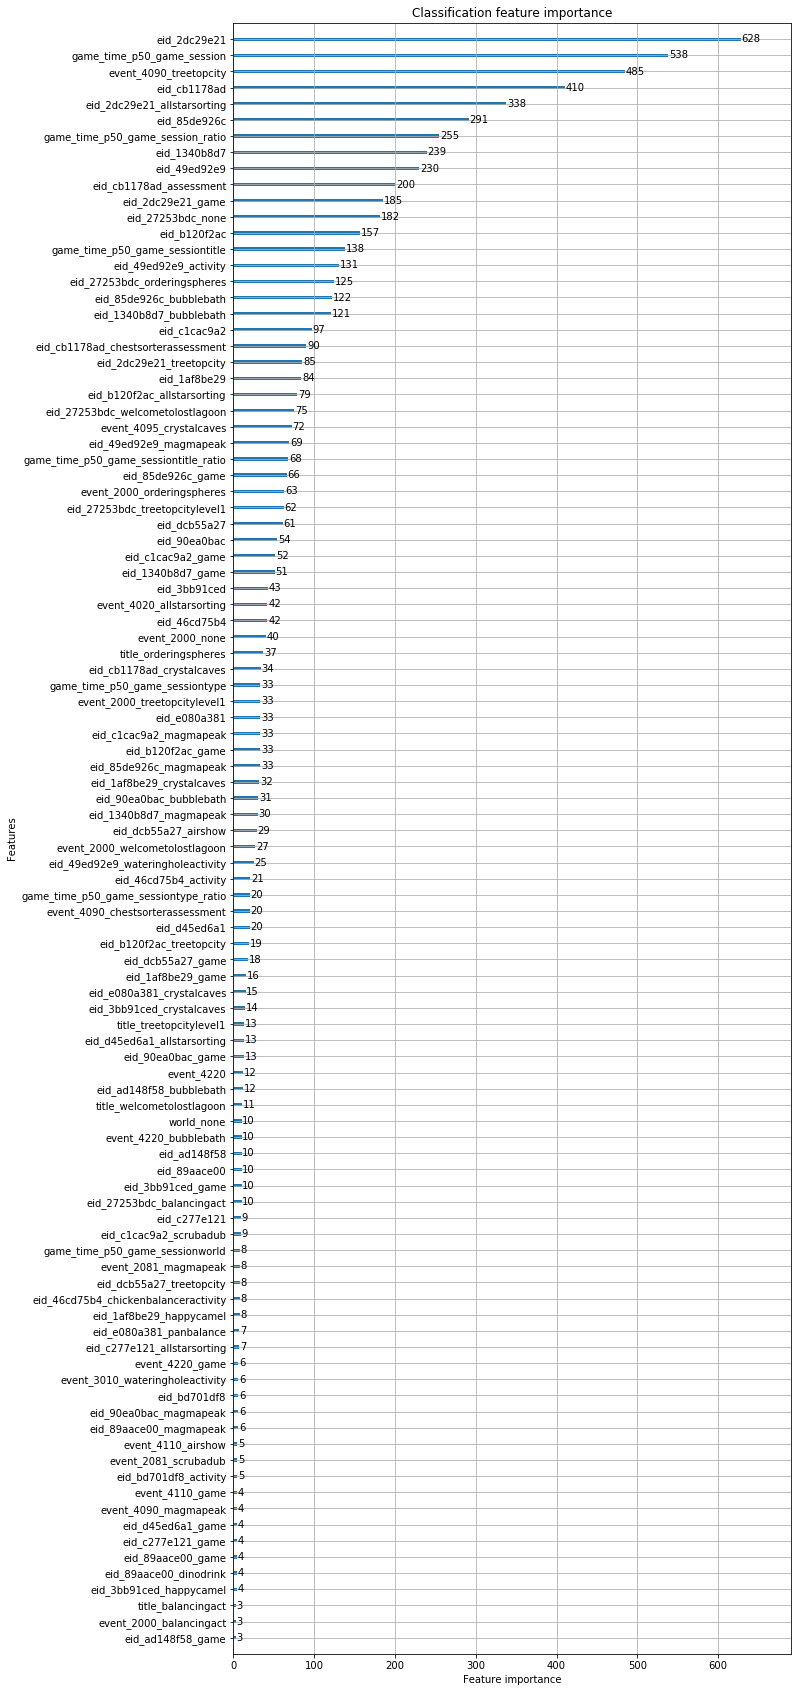

In [108]:
lgb.plot_importance(cls.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title='Classification feature importance')

# Regression on the number of attempts to solve the assessment

In [109]:
def _rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


SCORING = make_scorer(_rmse, greater_is_better = False)

In [119]:
%%time
tmp = train[train['is_solved'] == 1]
y_train = tmp['solved_attempts']
x_train = tmp[PREDICTORS]
model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__num_leaves': [8, 16],
    'model__min_child_samples': [100, 200],
    'model__colsample_bytree': [0.5, 0.25]
}
cv = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cv.fit(x_train, y_train)
_log(f'RMSE\nbest_params_={cv.best_params_}\nbest_score_={cv.best_score_:.5f}')

RMSE
best_params_={'model__colsample_bytree': 0.25, 'model__learning_rate': 0.001, 'model__min_child_samples': 100, 'model__num_leaves': 16}
best_score_=-0.78748
Wall time: 32min 12s


In [120]:
# plot_metric only works with early stopping rounds
#lgb.plot_metric(cv.best_estimator_['model'])

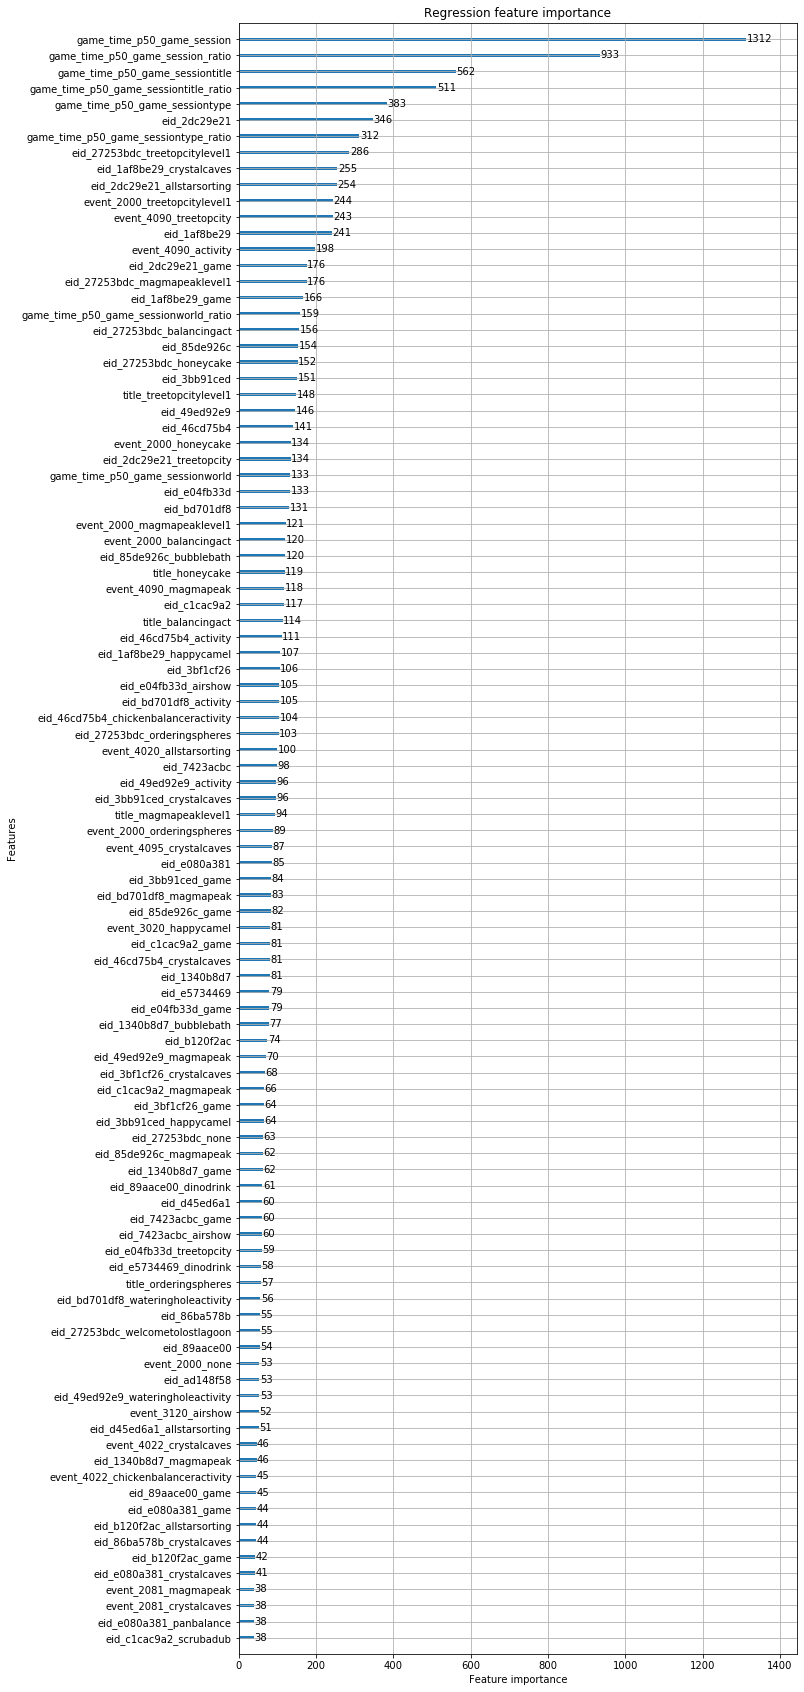

In [121]:
lgb.plot_importance(cv.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title='Regression feature importance')

# Predict out of fold

In [122]:
%%time
def _predict(df, classifier, regressor):
    res = df[['installation_id']].copy()
    res[TARGET] = np.nan
    x_cls = df[PREDICTORS]
    res['is_solved'] = classifier.predict(x_cls)
    iids = set(res[res['is_solved'] == 1]['installation_id'].values)
    cols = ['installation_id'] + PREDICTORS
    tmp = df[df['installation_id'].isin(iids)][cols].copy()
    x = tmp[PREDICTORS]
    tmp['solved_attempts_raw'] = regressor.predict(x)
    tmp = tmp[['installation_id', 'solved_attempts_raw']]
    res = res.merge(tmp, on='installation_id', how='left')
    res['solved_attempts'] = np.int16(np.round(res['solved_attempts_raw']))
    res.loc[res['is_solved'] == 0, [TARGET]] = 0
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] >= 3), [TARGET]] = 1
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] == 2), [TARGET]] = 2
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] <= 1), [TARGET]] = 3
    assert res[TARGET].notna().all(axis=None)
    res[TARGET] = np.int16(res[TARGET])
    return res


oof = _predict(train, classifier=cls, regressor=cv)
oof.head(10)

Wall time: 30.3 s


,installation_id,accuracy_group,is_solved,solved_attempts_raw,solved_attempts
0,0006a69f,2,1,1.677480,2
1,0006c192,2,1,1.501941,2
2,00129856,3,1,1.406411,1
3,001d0ed0,3,1,1.456390,1
4,00225f67,2,1,1.527958,2
5,00279ac5,2,1,1.709741,2
6,002db7e3,2,1,1.678492,2
7,003372b0,3,1,1.440389,1
8,004c2091,3,1,1.430149,1
9,00634433,2,1,1.628079,2


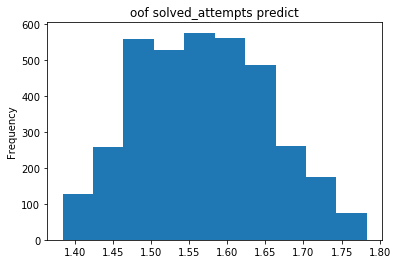

In [123]:
plt.title('oof solved_attempts predict')
oof['solved_attempts_raw'].plot(kind='hist')

In [124]:
oof = oof.sort_values(by=['installation_id'])
train = train.sort_values(by=['installation_id'])
score = cohen_kappa_score(oof[TARGET], train[TARGET], weights='quadratic')
_log(f'oof score={score:.5f}')

oof score=0.08951


# Predict on Test set

In [125]:
%%time
sub = _predict(test, classifier=cls, regressor=cv)
sub = sub[['installation_id', TARGET]]
sub.head()

Wall time: 25.9 s


,installation_id,accuracy_group
0,00abaee7,3
1,01242218,2
2,017c5718,3
3,01a44906,2
4,01bc6cb6,2


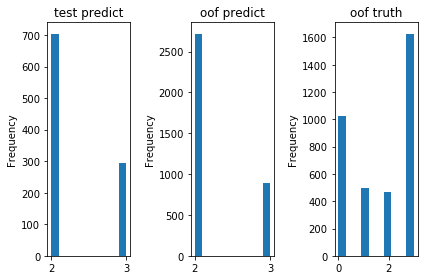

In [126]:
plt.subplot(1, 3, 1)
plt.title('test predict')
sub[TARGET].plot(kind='hist')
plt.subplot(1, 3, 2)
plt.title('oof predict')
oof[TARGET].plot(kind='hist')
plt.subplot(1, 3, 3)
plt.title('oof truth')
tmp = train[TARGET].copy()
tmp = tmp.astype(int)
tmp.plot(kind='hist')
plt.tight_layout()

In [127]:
sub.to_csv('submission.csv', index=False)
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'test_scaled.parquet', 'train.parquet', 'train_scaled.parquet']
